In [15]:
import chess
import chess.pgn
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
os.chdir('..')

In [2]:
FILENAME = None
asset_dir = 'asset'
assets_path = os.path.join(os.getcwd(), asset_dir)

from chess_class import ChessGame, ChessMove

# %%
def chess_games_to_arrays(games_generator):
    def rating_to_group(rating):
        rating = int(rating)
        if rating < 800:
            return 0
        elif rating >= 2400:
            return 9
        return int(rating)//200 - 3

    attributes = ["ply_count", "time_category", "classification_name", "count_legal_moves", "force_moves_percent",
                  "game_state", "distance", "is_endgame", "has_increment", "in_time_trouble", "can_dirty_flag",
                  "is_check", "is_double_check", "is_discovered_check", "is_capture", "is_threat", "is_developing",
                  "is_retreating", "was_hanging", "is_hanging", "was_true_hanging", "is_true_hanging", "is_create_tension",
                  "is_resolve_tension", "is_maintain_tension", "start_square", "end_square", "threats", 
                  "create_tension", "maintain_tension", "resolve_tension", "piece_value"]
    
    game_arrays = []
    ratings_list = []
    urls_list = []
    ply_counts = []
    max_games = 25
    for i, game in enumerate(tqdm(games_generator, total=max_games, desc="Processing games")):
        elo_w, elo_b, url = game.white_elo, game.black_elo, game.url
        total_plies = game.total_ply
        df = pd.DataFrame(columns=attributes)
        for j, move in enumerate(game.moves):
            move_row = {attribute: getattr(move, attribute, None) for attribute in attributes}
            df.loc[j] = move_row
        df['ply_count'] = df['ply_count'] / total_plies
        df['count_legal_moves'] = df['count_legal_moves'] / 128
        df['distance'] = (df['distance'] - 1) / 6

        df['prev_end_square'] = df['end_square'].shift(1).fillna(64)
        df['prev_threats'] = df['threats'].shift(1).fillna({}).apply(lambda x: x if isinstance(x, set) else {})
        df['prev_create_tension'] = df['create_tension'].shift(1).fillna({}).apply(lambda x: x if isinstance(x, set) else {})
        df['last_move_end_square'] = df['end_square'].shift(2).fillna(64)
        df['last_move_create_tension'] = df['create_tension'].shift(2).fillna({}).apply(lambda x: x if isinstance(x, set) else {})
        df['last_move_threats'] = df['threats'].shift(2).fillna({}).apply(lambda x: x if isinstance(x, set) else {})
    
        df['is_reacting'] = df.apply(lambda row: row['prev_end_square'] in (row['create_tension'] | row['threats']), axis=1) | \
                            (df['prev_end_square'] == df['end_square']) | \
                            df.apply(lambda row: row['start_square'] in row['prev_threats'], axis=1)
        df['is_same_piece'] = df['last_move_end_square'] == df['start_square']
        df['veni_vidi_vici'] = df.apply(lambda row: row['end_square'] in (row['last_move_create_tension'] | row['last_move_threats']), axis=1)
        df['is_collinear'] = df.apply(lambda row: row['start_square'] in (row['prev_create_tension'] | row['prev_threats']), axis=1) | \
                            df.apply(lambda row: row['prev_end_square'] in row['create_tension'], axis=1)
        df.drop(columns=['prev_end_square', 'last_move_end_square', 'prev_threats', 'last_move_create_tension', 'prev_create_tension',
                         'last_move_threats', 'threats', 'create_tension', 'maintain_tension', 'resolve_tension'], inplace=True)

        df['moved_piece_king'] = df['piece_value'].apply(lambda x: 1 if x == 6 else 0)
        df['moved_piece_queen'] = df['piece_value'].apply(lambda x: 1 if x == 5 else 0)
        df['moved_piece_rook'] = df['piece_value'].apply(lambda x: 1 if x == 4 else 0)
        df['moved_piece_bishop'] = df['piece_value'].apply(lambda x: 1 if x == 3 else 0)
        df['moved_piece_knight'] = df['piece_value'].apply(lambda x: 1 if x == 2 else 0)
        df['moved_piece_pawn'] = df['piece_value'].apply(lambda x: 1 if x == 1 else 0)
        df['time_category_instant'] = df['time_category'].apply(lambda x: 1 if x == 'instant' else 0)
        df['time_category_fast'] = df['time_category'].apply(lambda x: 1 if x == 'fast' else 0)
        df['time_category_normal'] = df['time_category'].apply(lambda x: 1 if x == 'normal' else 0)
        df['time_category_slow'] = df['time_category'].apply(lambda x: 1 if x == 'slow' else 0)
        df['classification_name_Great'] = df['classification_name'].apply(lambda x: 1 if x == 'Great' else 0)
        df['classification_name_Good'] = df['classification_name'].apply(lambda x: 1 if x == 'Good' else 0)
        df['classification_name_Inaccuracy'] = df['classification_name'].apply(lambda x: 1 if x == 'Inaccuracy' else 0)
        df['classification_name_Blunder'] = df['classification_name'].apply(lambda x: 1 if x == 'Blunder' else 0)
        df['classification_name_Mistake'] = df['classification_name'].apply(lambda x: 1 if x == 'Mistake' else 0)

        df = df.drop(['classification_name', 'time_category', 'piece_value', 'start_square', 'end_square'], axis=1)

        game_array_rep = df.astype(float).to_numpy()
        game_arrays.append(game_array_rep)
        ratings_list.append(rating_to_group((elo_w + elo_b)/2))
        urls_list.append(url)
        ply_counts.append(total_plies)
    return ply_counts, game_arrays, ratings_list, urls_list

# %%
def load_pgns(file_path, num_games=1, start_index=0, encoding="utf-8"):
    games = []
    with open(file_path, "r", encoding=encoding) as file:
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            games.append(game)
    return games

# %%
pgns = []
file_dir = 'asset/samples'
file_names = os.listdir(file_dir)
for f in file_names:
    file_name = f"{file_dir}/{f}"
    pgn = load_pgns(file_name, 1)
    pgns.append(pgn[0])

Loading games:   0%|          | 0/1 [00:00<?, ?game/s]

Loading games: 100%|██████████| 1/1 [00:00<00:00, 200.01game/s]


In [3]:
games_generator = (ChessGame(pgn) for pgn in pgns)
ply_counts, game_arrays, ratings_list, urls_list  = chess_games_to_arrays(games_generator)

# %%
input_size = 42
num_classes = 10
num_epochs = 40
sequence_length = 128
batch_size = 100
hidden_size = 100
num_layers = 3
learning_rate = 0.0008
alpha = 0.9
dropout_rate = 0
decay = 0.0001


def pad_game(game, max_length=256, vector_size=42):
    padding_length = max_length - len(game)
    if padding_length < 0:
        return game[:max_length]
    else:
        padding = np.full((padding_length, vector_size), -1)
        return np.vstack((game, padding))

padded_game = [pad_game(g, sequence_length) for g in game_arrays]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Processing games:  40%|████      | 10/25 [00:05<00:07,  1.91it/s]


In [4]:
len(padded_game)

10

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc_classification = nn.Linear(hidden_size, num_classes)
        self.fc_regression = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.lstm(x, (h0, c0))

        sequential_output = []
        for t in range(out.size(1)):
            step_out = out[:, t, :]
            step_out = self.dropout(F.relu(self.fc1(step_out)))
            step_out = self.dropout(F.relu(self.fc2(step_out)))
            step_out = self.dropout(F.relu(self.fc3(step_out)))
            step_out = self.dropout(F.relu(self.fc4(step_out)))
            step_out = self.dropout(F.relu(self.fc5(step_out)))
            step_out = self.dropout(F.relu(self.fc6(step_out)))
            step_out = self.dropout(F.relu(self.fc7(step_out)))
            regression_output = self.fc_regression(step_out)
            sequential_output.append(regression_output)
        
        sequential_output = torch.stack(sequential_output, dim=1)
        
        final_out = out[:, -1, :]
        classification_output = self.fc_classification(final_out)
        
        return classification_output, sequential_output.squeeze()

model_path = '2023_tc_50000_games_pred.pth'
model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device);

pred_by_move = []
for m, test_data in enumerate(padded_game):
    moves = torch.FloatTensor(np.array([test_data])).to(device)
    model.eval()
    with torch.no_grad():
        classification_output, sequential_regression_output = model(moves)
        pred_by_move.append(sequential_regression_output.cpu().numpy())

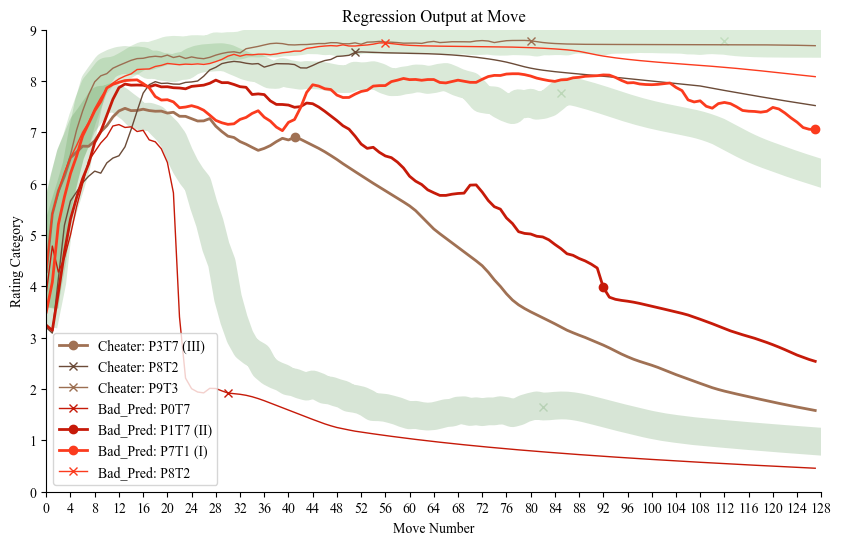

In [25]:
x_values = np.arange(0, 128)
data = np.array(pred_by_move)
colors = ['#3b8132','#46923c','#52a447','#a07154','#6b4b38','#9b6e51','#c61a09','#c61a09','#fb3b1e','#fb3b1e']
legends = [None, None, None, 'Cheater: P3T7 (III)', 'Cheater: P8T2', 'Cheater: P9T3', "Bad_Pred: P0T7", "Bad_Pred: P1T7 (II)", "Bad_Pred: P7T1 (I)", "Bad_Pred: P8T2"]

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(data.shape[0]):
    if i < 3:
        linewidth = 20
        alpha = 0.2
    else:
        linewidth = 2 if i in [3,7,8] else 1
        alpha = 1
    
    ax.plot(x_values, data[i, :], 
            #label=f"{file_names[i].split('.')[0]}", 
            label=legends[i],
            color=colors[i],
            marker='o' if i in [3,7,8] else 'x', 
            markevery=[x_values.tolist().index(ply_counts[i]) if ply_counts[i] in x_values else -1],
            linewidth=linewidth, 
            alpha=alpha)


ax.set_title('Regression Output at Move')
ax.set_xlabel('Move Number')
ax.set_ylabel('Rating Category')

ax.set_xlim(0, 128)
ax.set_ylim(0, 9)
ax.set_xticks(np.arange(0, 129, 4))
ax.set_yticks(np.arange(0, 10, 1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()
plt.show()
